<h1><span style="color:red">The RED exercise</span></h1>

Simulated patterns from each of ***two classes have been drawn from an identical distribution***. I.e. there is no true difference between them. A simple classification has been run for one participant, and the ***classifier returns a suspiciously high accuracy***. 

***What is the issue? Improve the analysis so that the classification score is not misleadingly high.*** There are multiple ways that this could be achieved - how many can you think of? How many can you implement?

Extension: run your improved analysis for 35 subjects and confirm that your classification score is not significantly higher than a chance level equivalent to 50% accuracy.

## Getting ready

Import the packages we might need:

In [11]:
import numpy as np # This lets python process matrices, like Matlab
import matplotlib.pyplot as plt # This lets python plot graphs like Matlab

# scikit-learn is the major library for machine learning in Python:
import sklearn as skl
from sklearn import preprocessing # includes LabelEncoder, OneHotEncoder, StandardScaler...
from sklearn import model_selection # includes StratifiedKFold, LeaveOneGroupOut...
from sklearn import linear_model # includes LogisticRegression, RidgeClassifier...
from sklearn import svm # includes SVC, NuSVC & LinearSCV...
from sklearn import discriminant_analysis # includes LinearDiscriminantAnalysis
from sklearn import metrics # includes roc_auc_score...
from sklearn import pipeline # includes make_pipeline


Set the random number generator:

In [12]:
np.random.seed(3)

## Simulate the data with no true difference between conditions:

In [13]:
nvox = 2 # number of voxels
nruns= 4 # number of runs
n_samples_per_run = 10 # number of samples/patterns per run; these will be divided into conditions/classes "0" and "1"
proportion_of_samples_from_condition_0 = 0.8

mu = np.arange(nvox) # mean activation for both conditions (voxels all have different activation strength)
voxel_covariance = np.diag(mu) + 1 # voxel covariance for both conditions: independent noise per voxel is proportional to mean, plus some covariance

null_data_per_run = [] # list of pattern matrices (one for each run)
labels_per_run = []    # list of label vectors (one for each run)
for r in np.arange(nruns):
    # activations are drawn from THE SAME DISTRIBUTION FOR BOTH CONDITIONS!
    data_matrix =  np.random.multivariate_normal(mu, voxel_covariance, size=n_samples_per_run) 

    # label each sample as condition 0 or 1 (the +0 is a trick to convert the logical values to integers):
    label_vector= ((np.arange(n_samples_per_run)/n_samples_per_run)>=proportion_of_samples_from_condition_0)+0;
    
    null_data_per_run.append( data_matrix ) 
    labels_per_run.append( label_vector ) 

# concatenate runs
null_data   = np.concatenate(null_data_per_run, axis=0)             
labels      = np.concatenate(labels_per_run, axis=0)
run_indices = np.concatenate([[i] * n_samples_per_run for i in range(nruns)])

\
Plot the data for the first two voxels:

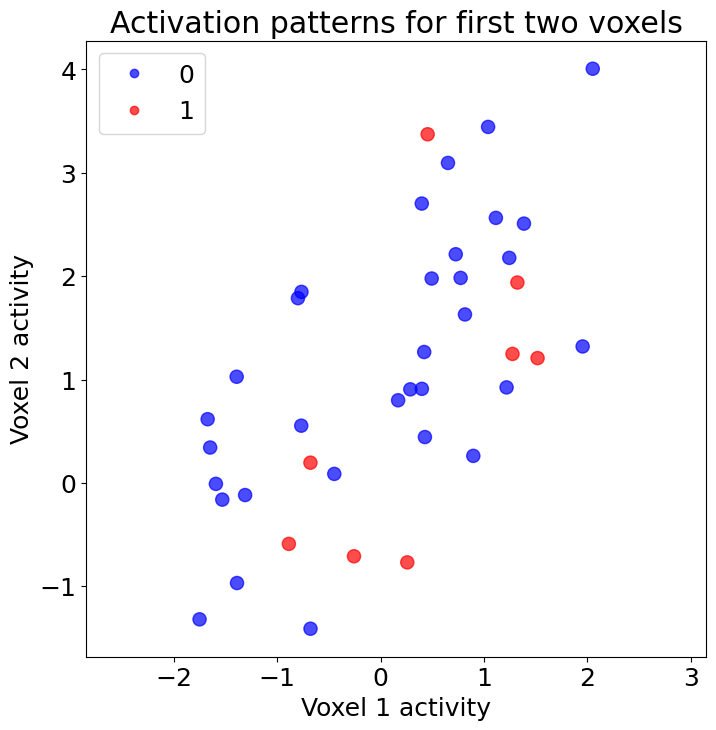

In [14]:
plt.figure(figsize=(8,8))  # create a matplotlib figure
plt.title('Activation patterns for first two voxels')
scatter = plt.scatter(null_data[:,[0]], null_data[:,[1]], 
                      s= 90, alpha=0.7, c=labels, cmap='bwr')
plt.legend(handles=scatter.legend_elements()[0], labels=set(np.unique(labels))) # "set" returns unique values
plt.xlabel('Voxel 1 activity')
plt.ylabel('Voxel 2 activity')
plt.rcParams.update({'font.size': 18})
plt.axis('equal')
plt.show()

\
Specify the pre-processing, classification pipeline, and a leave-one-run-out cross-validation scheme:

In [15]:
scaler = skl.preprocessing.MinMaxScaler()
SVM    = skl.svm.LinearSVC(dual=True)
pipe   = skl.pipeline.make_pipeline(scaler, SVM)
logo   = skl.model_selection.LeaveOneGroupOut()

\
Run the classification analysis, with a fair bit of code:

In [16]:
folds = tuple(logo.split(null_data, labels, run_indices))
accuracy = np.full(nruns,np.nan)
for i, fold in enumerate(folds):
    train_idx, test_idx = fold # get the train and test indices
    pipe.fit(null_data[train_idx,:], labels[train_idx]) # do all preprocessing and model fitting on training data
    predicted_labels = pipe.predict(null_data[test_idx,:])     # do prediction on test data
    accuracy[i] = skl.metrics.accuracy_score(labels[test_idx], predicted_labels) # score the predictions
print("Accuracy per fold:", accuracy)
print("Mean accuracy for random data:", np.mean(accuracy))

Accuracy per fold: [0.8 0.8 0.8 0.8]
Mean accuracy for random data: 0.8


\
...or run it the quick way:

In [17]:
accuracy = skl.model_selection.cross_val_score(pipe, null_data, labels, groups  = run_indices, cv = logo, scoring = 'accuracy')

print("Accuracy per fold:", accuracy)
print("Mean accuracy for random data:", np.mean(accuracy))

Accuracy per fold: [0.8 0.8 0.8 0.8]
Mean accuracy for random data: 0.8


## Questions:
 - We have two classes, drawn from the same distribution, so why is accuracy not close to 0.5?
 - Is the classifier performing as it should?
 - Can you change the analysis to get a classification score closer to a level equivalent to 50% accuracy? There are multiple ways that this could be achieved - how many can you think of? How many can you implement?

## Hints:
- Consider the data that are being provided to the classifier per class.
- Think about the choice of performance metric.
- Consider other options when specifying the classifier.

Extension: run your improved analysis for 35 subjects and confirm that your classification score is not significantly higher than a chance level equivalent to 50% accuracy.

## Explanation and possible solutions

The problem here is that the dataset is **unbalanced**, i.e. there are more samples in one class than the other. This means that a naive classifier can always guess that samples come from the over-represented class, even without looking at the data, and be correct most of the time. Note that the classifier is doing exactly what it is supposed to: maximizing its average classification performance. The issue is that the classifier can use information in the class proportions, whereas we are only interested in information it can get from the patterns.

The easiest solution is to **use a performance metric that adjusts for any bias due to imbalanced classes**. The area under the ROC curve, and other signal-detection-theory-based metrics (e.g. d') do this. There is also a variant of "accuracy" called "balanced accuracy", which essentially scores the accuracy per class and then averages these. Note that these metrics ensure that the performance estimate is not biased by any imbalance, but they do not prevent the classifier from learning the class imbalance in the first place. Therefore sensitivity can still be reduced in the presence of severe imbalance (see the ORANGE exercise). 

Another set of solutions is to **ensure that the classes are balanced within each training set**. Ideally this would be done when designing the experiment, but sometimes it is not possible: some conditions may necessarily be rarer than others; assignment of samples to classes might depend on something that can't be controlled, such as behaviour; samples may be missing at random due to technical faults or noisy data. Another option is to randomly sub-sample the over-represented class until the classes are balanced. This is not ideal, because it is not straightforward, it reduces the amount of training data, and because repeated subsampling can be time-consuming. A related option could be to create additional "pseudo-samples" for the under-represented class, by randomly averaging the available samples. This is also time-consuming, tricky to set up, and may not make sense depending on the context.

Yet another solution is to **tell the classifier about the imbalance** when training it (so that it can emphasise information in the patterns). This requires the particular classifier implementation to have this option. Typically it works by proportionally up-weighting samples from the under-represented class. 

Let's try these three approaches:

### 1) Use a performance metric that is not biased by unbalanced classes:

In [18]:
balanced_accuracy = skl.model_selection.cross_val_score(pipe, null_data, labels, groups  = run_indices, cv = logo, scoring = 'balanced_accuracy')

print("Balanced accuracy per fold:", balanced_accuracy)
print("Mean balanced accuracy for random data:", np.mean(balanced_accuracy))

Balanced accuracy per fold: [0.5 0.5 0.5 0.5]
Mean balanced accuracy for random data: 0.5


"Chance level" is now 0.5.

### 2) Sub-sample the over-represented class:
This is a bit more involved...

In [19]:
accuracy = np.full(nruns,np.nan)
for i, fold in enumerate(folds):
    train_idx, test_idx = fold # get the train and test indices
    ############# the new bit:
    min_sample_per_class= np.min(np.bincount(labels[train_idx]))
    sort_vec = np.argsort(labels[train_idx])
    train_idx= np.concatenate((train_idx[sort_vec[0:min_sample_per_class]], train_idx[sort_vec[-min_sample_per_class:]]))
    #############
    pipe.fit(null_data[train_idx,:], labels[train_idx])    # do all preprocessing and model fitting on training data
    predicted_labels = pipe.predict(null_data[test_idx,:]) # do prediction on test data
    accuracy[i] = skl.metrics.accuracy_score(labels[test_idx], predicted_labels) # score the predictions
print("Accuracy per fold:", accuracy)
print("Mean accuracy for random data:", np.mean(accuracy))

Accuracy per fold: [0.5 0.4 0.4 0.7]
Mean accuracy for random data: 0.5


Accuracy estimates are now centred on 0.5 (even using simple "accuracy"), but notice that they are also more variable.

### 3) Tell the classifier to adjust for imbalance by reweighting samples:

In [20]:
########### the new bit:
SVM    = skl.svm.LinearSVC(dual=True, class_weight='balanced')
########################
pipe   = skl.pipeline.make_pipeline(scaler, SVM)

accuracy = skl.model_selection.cross_val_score(pipe, null_data, labels, groups  = run_indices, cv = logo, scoring = 'accuracy')

print("Accuracy per fold:", accuracy)
print("Mean accuracy for random data:", np.mean(accuracy))

Accuracy per fold: [0.5 0.4 0.6 0.7]
Mean accuracy for random data: 0.55


As above, accuracy estimates are now close to 0.5 (even using simple "accuracy"), but again notice that they are also more variable.